# SEGMENTATION BASED ON PIXEL-SIMILARITY

This notebook shows that given a pixel-similarity matrix we can easily recover the segmentation masks doing a spatial aware agglomerative-clustering procedure.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
exp = None
#import neptune
#neptune.set_project('dalessioluca/neurons')
#exp = neptune.create_experiment(name='5_neurons_exploration')    

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import numpy 
import torch
import skimage.filters
from util_luca import *
from sklearn.neighbors import radius_neighbors_graph
from sklearn.cluster import AgglomerativeClustering

device = torch.device("cpu")
dtype = torch.float32

### Ingest the data

In [57]:
data_dir = '/Users/ldalessi/REPOS/Optosynth/DATA/test_data_5neurons/'

file_list = next(iter(os.walk(data_dir)))[2]

print(data_dir)
print(file_list)

#soma_coords_n2 = numpy.load(os.path.join(data_dir,"soma_coords_n2.npy"))
noisy_movie_tyx = numpy.load(os.path.join(data_dir,"noisy_movie_tyx.npy"))
clean_movie_tyx = numpy.load(os.path.join(data_dir,"clean_movie_tyx.npy"))
masks_nyx = numpy.load(os.path.join(data_dir,"masks_nyx.npy"))
#background_tyx = numpy.load(os.path.join(data_dir,"background_tyx.npy"))
#clean_fluorescence_tyx = numpy.load(os.path.join(data_dir,"clean_fluorescence_tyx.npy"))
neuron_mean_fluorescence_nt = numpy.load(os.path.join(data_dir,"neuron_mean_fluorescence_nt.npy"))

/Users/ldalessi/REPOS/Optosynth/DATA/test_data_5neurons/
['noisy_movie_tyx.npy', 'clean_fluorescence_tyx.npy', 'neuron_mean_fluorescence_nt.npy', 'background_tyx.npy', 'soma_coords_n2.npy', 'clean_movie_tyx.npy', 'masks_nyx.npy']


# Input and matrix multiplications 

- generative model: Y =  A X + noise (where Y =[time,pixel], A=[time, sources] and X=[sources, pixel])
- correlation between pixels: corr = X^T X  where X = (A^T A)^(-1) A^T Y
- optimal denoiser: clean = A X = A (A^T A)^(-1) A^T Y 

The point is that: 
1. the optimal denoiser must have learned about pixel-correlation (how else can you denoise?). 
2. from the denoiser we read off the pixel-correlation and by clustering technique we obtain X = [source, pixel]
4. now with Y (the noisy observation) and X we can easily solve the NMF decomposition problem.

General strategy for de-mixing:
1. instead of solving NMF directly, we do UNET denoising and obtain as a by-product the correlation matrix (not that we do not need to do matrix inversion!)
2. by clustering (i.e. single-linkage) we decompose correlation_matrix into X and X^T
3. Now that you now X you cal solve Y = A X easily because you already know two matrices (Y and X)

This general strategy works for all de-mixing problems (single cell counts, images etc)

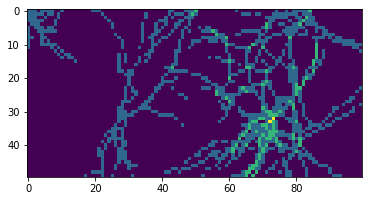

In [58]:
plt.imshow(numpy.sum(masks_nyx, axis=-3)[:150:3,100:400:3])

### Note that I slide thise tensor a bit b/c otherwise they are too big to fit into memory (especially pixel-pixel corr)

In [6]:
X = torch.from_numpy(masks_nyx[:,:150:3,100:400:3])
A = torch.from_numpy(neuron_mean_fluorescence_nt[:,-2000::2]).t() # time, source
Y = torch.from_numpy(noisy_movie_tyx[-2000::2,:150:3,100:400:3])
clean_movie = torch.from_numpy(clean_movie_tyx[-2000::2,:150:3,100:400:3])

X_flattened = X.flatten(start_dim=-2)  # source, pixel
Y_flattened = Y.flatten(start_dim=-2)  # time, pixel

In [7]:
print(X_flattened.shape)  # source, pixel
print(A.shape)            # time, source
print(Y_flattened.shape)  # time, pixel

torch.Size([5, 5000])
torch.Size([1000, 5])
torch.Size([1000, 5000])


# Visual inspection of X from noisy movie

In [8]:
At_Y = torch.matmul(A.t(), Y_flattened)  # source, pixel   
At_A = torch.matmul(A.t(), A)
At_A_inv = torch.inverse(At_A)
X_check = torch.matmul(At_A_inv, At_Y)

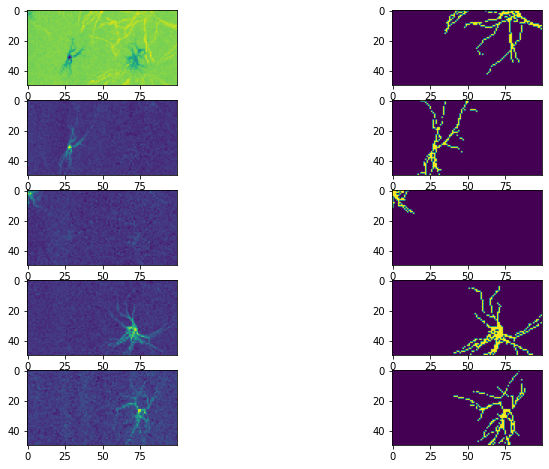

In [9]:
X_tmp = X_check.view_as(X)

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(12,8))
axes[0,0].imshow(X_tmp[0].numpy())
axes[0,1].imshow(X[0].numpy())

axes[1,0].imshow(X_tmp[1].numpy())
axes[1,1].imshow(X[1].numpy())

axes[2,0].imshow(X_tmp[2].numpy())
axes[2,1].imshow(X[2].numpy())

axes[3,0].imshow(X_tmp[3].numpy())
axes[3,1].imshow(X[3].numpy())

axes[4,0].imshow(X_tmp[4].numpy())
axes[4,1].imshow(X[4].numpy())

# From Correlation matrix to segmentation

1. transform the segmentation mask into mixing probabilities
2. compute the affinity between pixels as a dot product between mixing probabilities
3. compute the distance = 1.0 - affinity
4. perform a spatially aware single-linkage clustering
5. filter out small clusters

torch.Size([5000, 5000])


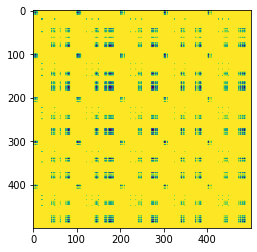

In [20]:
X_tmp = X_flattened.float() / torch.sum(X_flattened, dim=0, keepdims=True).clamp(min=1.0) #transform into mixing porbabilities
affinity = torch.matmul(X_tmp.t(), X_tmp)
distance = 1.0 - affinity
print(distance.shape)
plt.imshow(distance[:500,:500])

### Spatial Aware AgglomerativeClustering

In [ ]:
time, w, h = Y.shape
position = torch.stack(torch.meshgrid(torch.arange(0,w), torch.arange(0,h)), dim=0)
R = position.flatten(start_dim=1).t() 

print("position.shape ->", position.shape)  # 2, w, h
print("distance shape ->", distance.shape)      # pixel, pixel (i.e. n_samples, n_samples)
print("R shape -------->", R.shape)         # pixel, 2     (i.e. n_samples, n_features)

In [53]:


spatial_graph = radius_neighbors_graph(R, radius=8, mode='connectivity',
                                       metric='minkowski', p=2, metric_params=None, 
                                       include_self=False, n_jobs=None)

model = AgglomerativeClustering(n_clusters=None, 
                                affinity="precomputed", 
                                compute_full_tree=True,
                                compute_distances=True,
                                memory='./caching', 
                                connectivity=spatial_graph, 
                                linkage="single", 
                                distance_threshold=0.5)

model.fit(distance)

AgglomerativeClustering(affinity='precomputed', compute_distances=True,
                        compute_full_tree=True,
                        connectivity=<5000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 882956 stored elements in Compressed Sparse Row format>,
                        distance_threshold=0.5, linkage='single',
                        memory='./caching', n_clusters=None)

### Compare inferred clusters to ground truth clusters

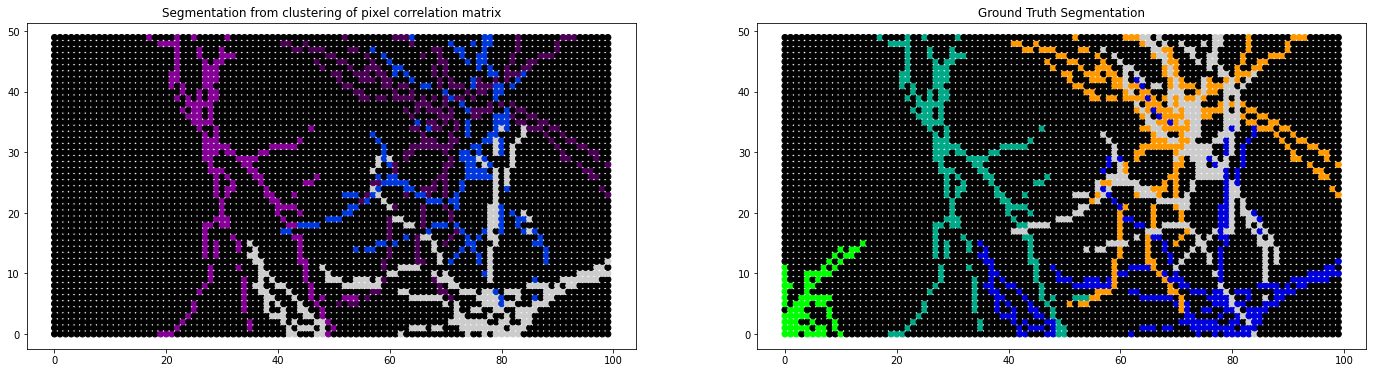

In [56]:
# these lines are for filtering out the cluster smaller than size_min pixel
size_min = 100
sizes = numpy.bincount(model.labels_)
mask_sizes = (sizes > size_min)
n_big_cluster = numpy.sum(mask_sizes)
n_all_cluster = model.n_clusters_ 
bad_to_good_labels = mask_sizes * numpy.arange(model.n_clusters_) -1 * ~mask_sizes

# Plot the clusters
fig, ax = plt.subplots(ncols=2, figsize=(24,6))
ax[0].scatter(R[:,1], R[:,0], 
              c=bad_to_good_labels[model.labels_], 
              cmap=plt.cm.nipy_spectral)  
_ = ax[0].set_title("Segmentation from clustering of pixel correlation matrix")

# Ground truth
index = torch.arange(X_flattened.shape[0])+1
gt_integer_mask = torch.max(X_flattened * index.unsqueeze(-1), axis=0)[0]

ax[1].scatter(R[:,1], R[:,0], 
              c=integer_mask, 
              cmap=plt.cm.nipy_spectral)  
_ = ax[1].set_title("Ground Truth Segmentation")